### 1. Settings

In [3]:
import warnings
warnings.filterwarnings("ignore")
import os,pickle,sys,re,glob
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nxcom
from importlib import reload
#customized module
from fun import network_analysis

cwd = os.getcwd()
datapath=cwd+'/../working-folder'
outputpath=cwd+'/data'
#For coding, if necessary
#reload(network_analysis)
gAssem=network_analysis.geneAssemClass(cwd,datapath,outputpath)
#Create directory to store the *pooled* differential gene expression data
pooled_diff_gene_exp_data=datapath+'/diff-gene-expression-matrix'
#Create directory to store edge weight distribution
edge_distr_data_dir = datapath+'/edge-distribution'
#Create directory to store null edge weight distribution
null_distr_data_dir = datapath+'/null-distribution'
pickled_objects_dir = datapath+'/pickled-files'
#data to be shared in the publication
publication_dir=outputpath

comparisons=['ATB_v_HC','ATB_v_LTBI','ATB_v_OD','ATB_v_Tret']

### 2. Build the differential gene expression matrix across the datasets
1. $|\log_2(FC)| > \log_2(1.5)$
1. $\text{BH adjusted pval} \le 0.05$

In [2]:
#set thresholds for logFC & pval
logFC_thresh = np.log2(1.5)
pval_thresh = 0.05 #0.01, 0.005, 0.001
#Two types of cutoffs will be tested. 1)fc=1.5, qvalue=0.01. 2)fc=1.5, qvalue=0.05

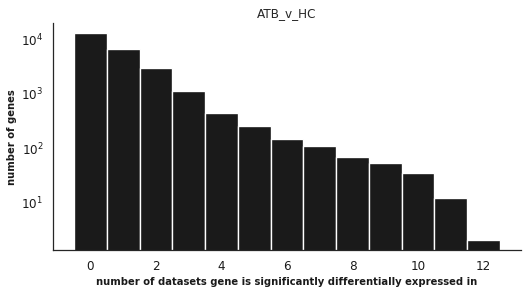

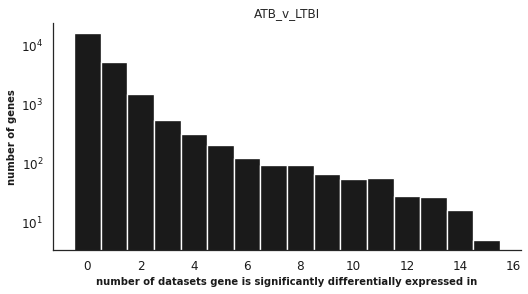

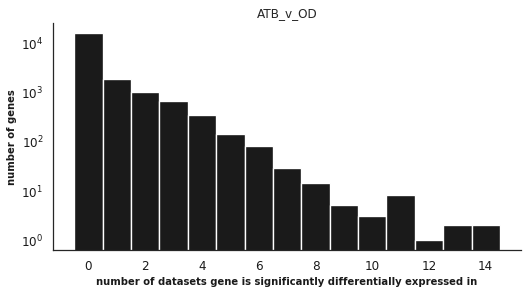

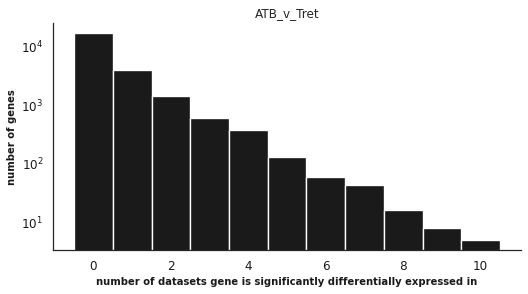

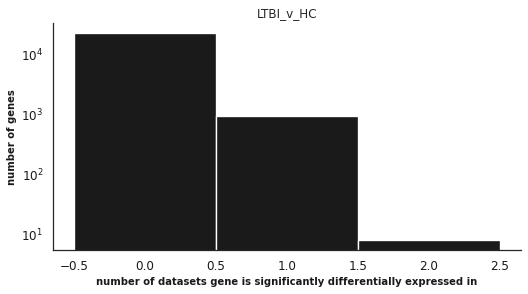

In [3]:
num_datasets_per_comparison=dict()
#Assemble the files from four folders
for e in comparisons:
    #construct a set of non-redundant genes across all studies for index of DataFrame  
    tar=datapath+'/diff-gene-expression/'+e;
    glist=gAssem.allgene(tar)
    met_full=pd.DataFrame(np.zeros((len(glist),len(listdir(tar)))),
                      index=glist,
                      columns=[re.sub('_array.csv|_seq.csv','',f) for f in listdir(tar)]);
    met_sel=met_full.copy()
    #Fill gene logfc values
    c=0
    for f in listdir(tar):
        c=c+1
        gmod=gAssem.dataFetch(tar+'/'+f)
        #All genes
        met_full.loc[gmod.index,re.sub('_array.csv|_seq.csv','',f)]=gmod.loc[:,'logFC']
        #only genes fit the thresholds 
        gmod_fit=gmod.loc[(abs(gmod['logFC'])>logFC_thresh) & (gmod['adj.P.Val']<=pval_thresh),]
        met_sel.loc[gmod_fit.index,re.sub('_array.csv|_seq.csv','',f)]=gmod_fit.loc[:,'logFC']
    #count how many studies in each comparisons
    num_datasets_per_comparison[e]=c
    met_full.to_csv(pooled_diff_gene_exp_data+'/'+e+'_fll.csv',index=True)
    met_sel.to_csv(pooled_diff_gene_exp_data+'/'+e+'_qval_thresh_'+str(pval_thresh)+'.csv',index=True)
    
    #Explore the matrix
    #Across how many datasets was each gene *significantly* differentially expressed in?
    t=met_sel.copy()
    t[t!=0]=1
    a=np.sort(np.array(t.sum(axis=1)))[::-1]
    #network_building_Fig1
    gAssem.histplot(a,e,publication_dir+'/network_building_fig1_'+e)

### 3. Explore network's edge weight distribution

##### 3.1 Compute edges (and corresponding weights) and *NULL* distributions from different comparisons and store as pickled objects

In [ ]:
for e in comparisons:
    #construct distribution of edge weights 
    edge_weight_distr_counter_dict,edge_weight_distr,edge_weight_labels = gAssem.edge_weight_distribution(pooled_diff_gene_exp_data+'/'+e+'_qval_thresh_'+str(pval_thresh)+'.csv')
    #output the edge distribution as a pickled object for later analysis
    with open(edge_distr_data_dir+'/'+e+'_qval_thresh_'+str(pval_thresh)+'.pickle' , 'wb') as handle1:           
        pickle.dump((edge_weight_distr_counter_dict,edge_weight_distr,edge_weight_labels), handle1, protocol=pickle.HIGHEST_PROTOCOL)
        
    #get the null distribution of edge weights (shuffle columns within each row, repeat process and add to bucket N times)
    edge_weight_null_distr_counter_dict = gAssem.edge_weight_null_distribution(pooled_diff_gene_exp_data+'/'+e+'_qval_thresh_'+str(pval_thresh)+'.csv', 25)
    #output the null distribution as a pickled object for later analysis
    with open(null_distr_data_dir+'/'+e+'_qval_thresh_'+str(pval_thresh)+'.pickle' , 'wb') as handle2:
        pickle.dump(edge_weight_null_distr_counter_dict, handle2, protocol=pickle.HIGHEST_PROTOCOL)

##### 3.2 Compare *Null* distributions to *Actual* distribution of edge weights for different comparison groups

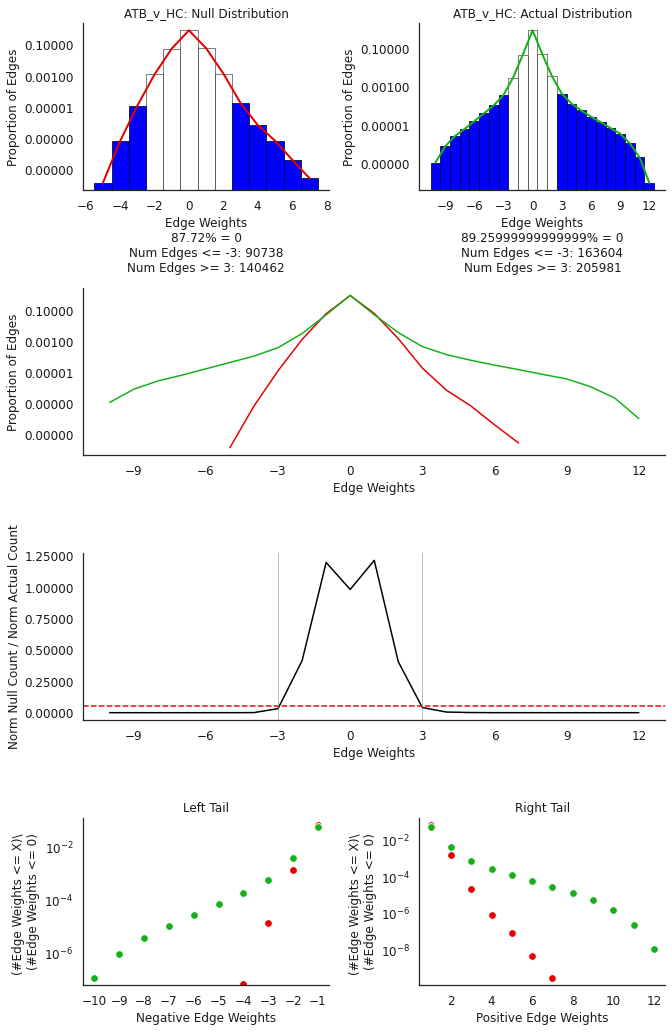

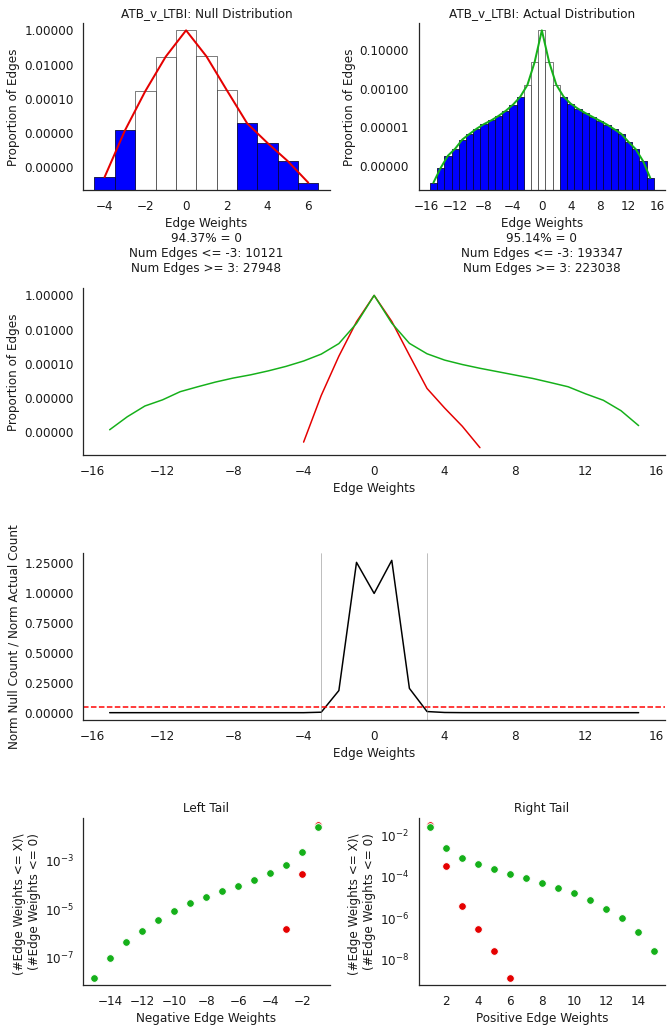

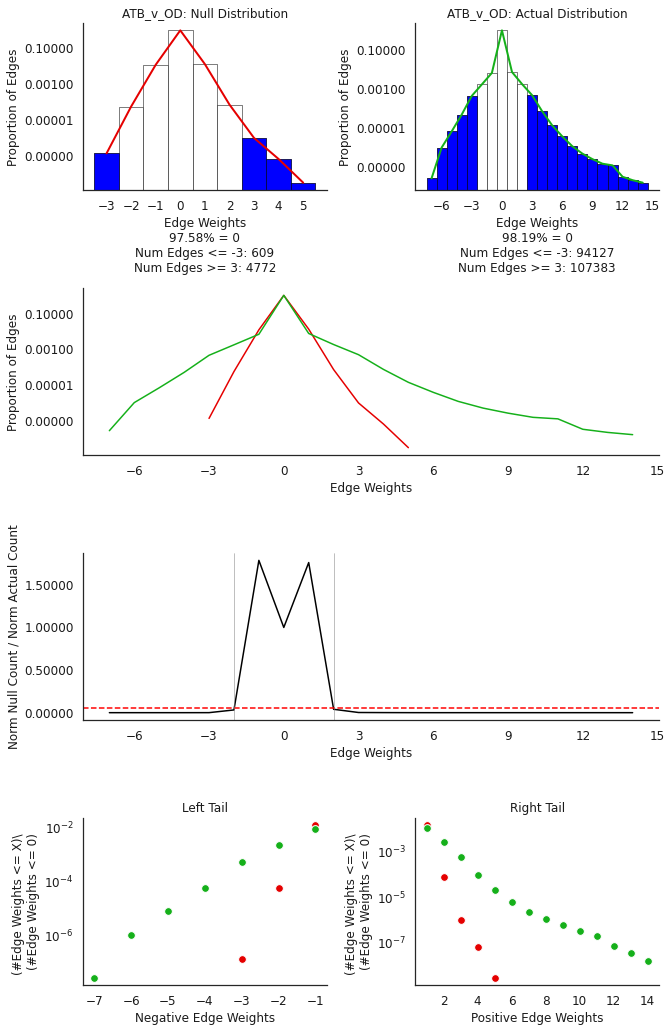

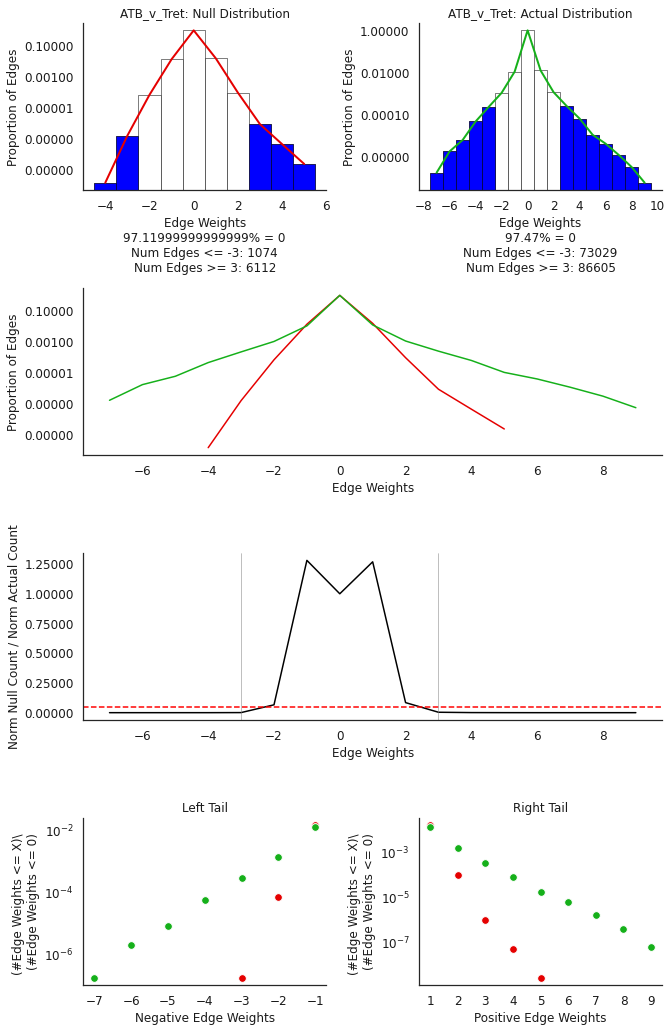

In [11]:
for e in comparisons:
    #get the edge weight distribution 
    with open(edge_distr_data_dir+'/'+e+'_qval_thresh_'+str(pval_thresh)+'.pickle', 'rb') as handle1:
        edge_weight_distr_counter_dict,edge_weight_distr,edge_weight_labels = pickle.load(handle1)
    #get the null distribution of edge weights (already generated and stored as a pickle)
    with open(null_distr_data_dir+'/'+e+'_qval_thresh_'+str(pval_thresh)+'.pickle', 'rb') as handle2:
        edge_weight_null_distr_counter_dict = pickle.load(handle2)
    #network_building_fig2
    gAssem.plot_null_v_actual_distributions(edge_weight_distr_counter_dict, edge_weight_null_distr_counter_dict, e, publication_dir+'/network_building_fig2_'+e)

### 4. Construct NetworkX graph from edge weight matrix
#### Retrieve the indices for the upper-triangular part of the matrix, normalize edge weights & construct list of edges
Have to (1) retrieve the edges from the upper-triangle of the matrix, (2) convert all to positive edge weights & (3) divide by the number of datasets

Comparison:ATB_v_HC
Graph with 2229 nodes and 369585 edges


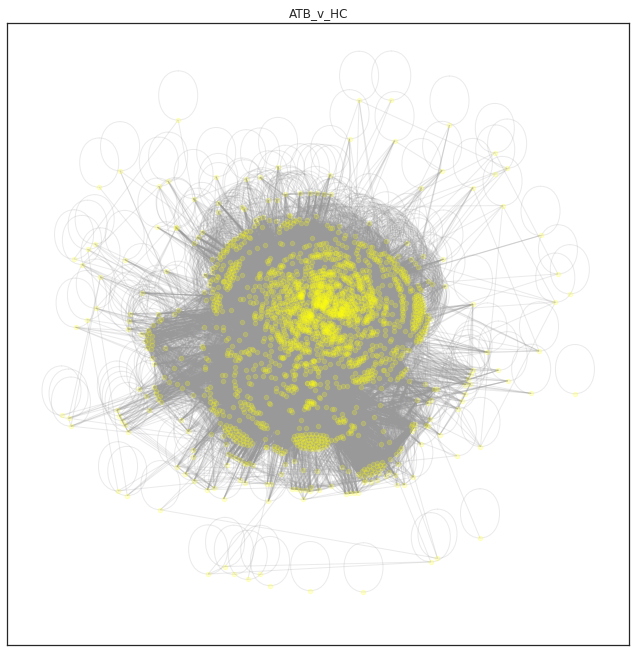

Comparison:ATB_v_LTBI
Graph with 1644 nodes and 416385 edges


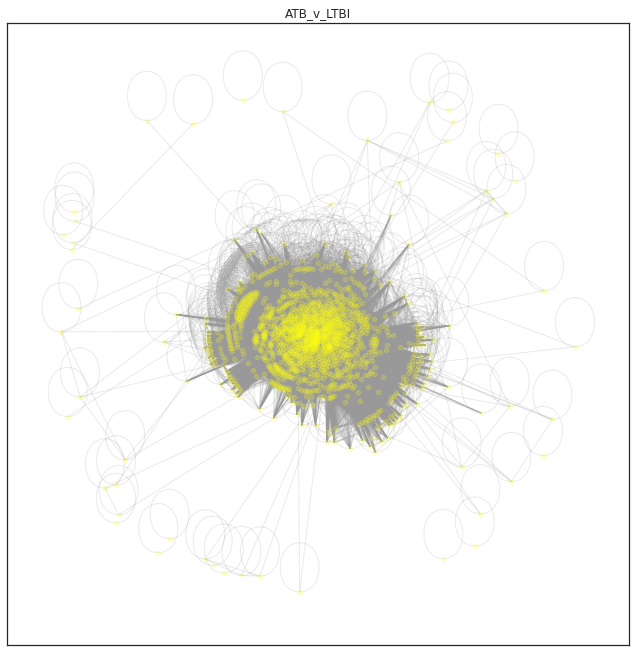

Comparison:ATB_v_OD
Graph with 1282 nodes and 201510 edges


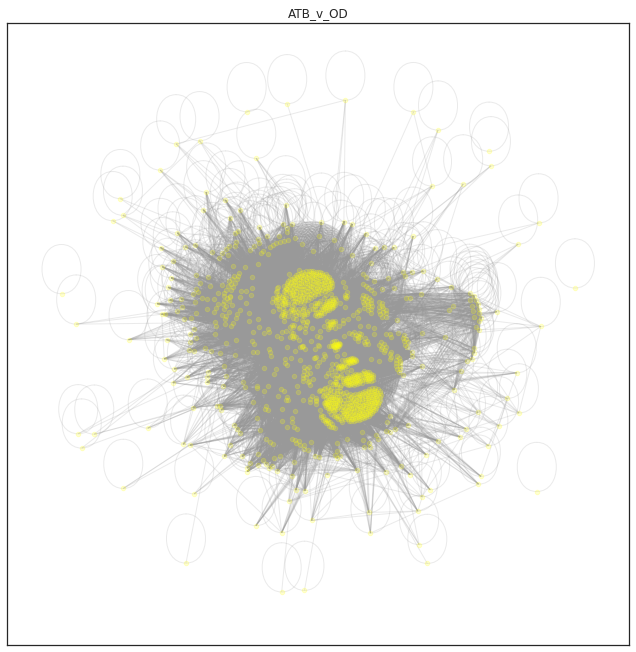

Comparison:ATB_v_Tret
Graph with 1093 nodes and 159634 edges


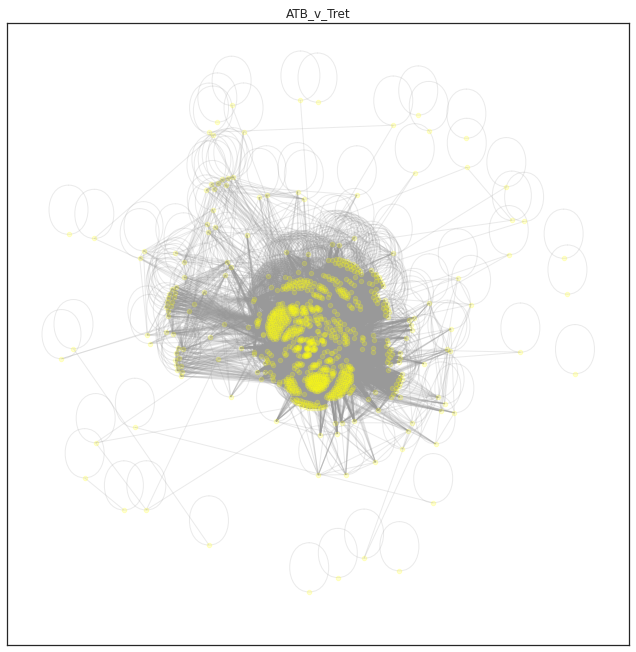

In [14]:
for e in comparisons:
    print('Comparison:'+e)
    #get the edge weight distribution 
    with open(edge_distr_data_dir+'/'+e+'_qval_thresh_'+str(pval_thresh)+'.pickle', 'rb') as handle1:
        edge_weight_distr_counter_dict,network_edge_weight_matrix,network_edge_weight_matrix_labels = pickle.load(handle1)
    
    #Return the upper triangular part of the matrix with elements in lower part ZEROED out
    upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

    #Return a boolean for elements in the upper triangular part of the matrix for elments that are <= -3 OR >= 3
    #The pvalue at edge weight=3 shows statistically different compared to null distribution 
    upper_tri_network_edge_weight_matrix_bool = abs(upper_tri_network_edge_weight_matrix) >= 3

    #get the indices for the elements in the upper triangle where elements (edge weights) <= -3 OR > 3
    node_i_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[0]
    node_j_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[1]

    #get the normalization factor (number of datasets used to construct edge weights = maximum possible weight)
    edge_weight_norm_factor = float(num_datasets_per_comparison[e])

    #Create list of edges for NetworkX graph by iterating through numpy (adjancency) matrix (with edge weights) + 
    #node labels (rows/columns of matrix) & storing edges with weights <= -3 OR >= 3
    G_edge_list = [ ( network_edge_weight_matrix_labels[node_i], network_edge_weight_matrix_labels[node_j], 
                     (float(abs(network_edge_weight_matrix[node_i, node_j]))/edge_weight_norm_factor) ) 
                   for node_i, node_j in zip(node_i_indices, node_j_indices)]
    
    # Construct NetworkX graph from list of Edges
    G = nx.Graph()
    G.add_weighted_edges_from(G_edge_list)
    nx.write_gpickle(G , pickled_objects_dir + '/network-files/networks/'+e+'.pkl')
    print(nx.info(G))
    
    #Plot the network
    gAssem.networkplot(G,e)

### 5. Centrality of Nodes from NetworkX graph

Comparison:ATB_v_HC


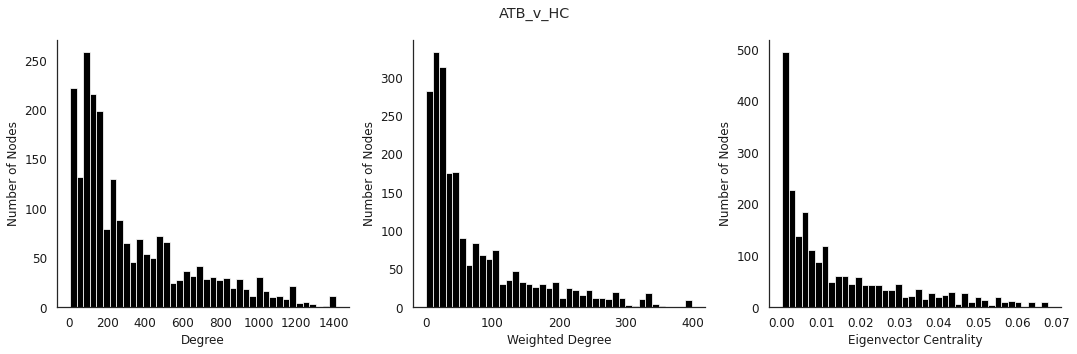

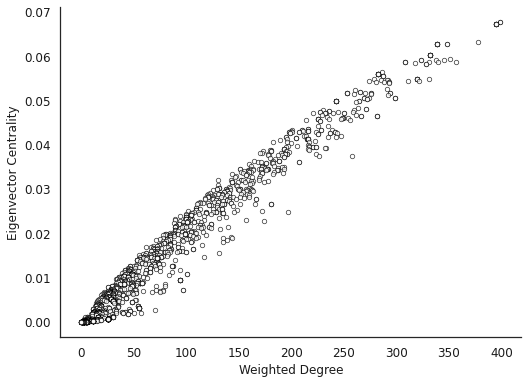

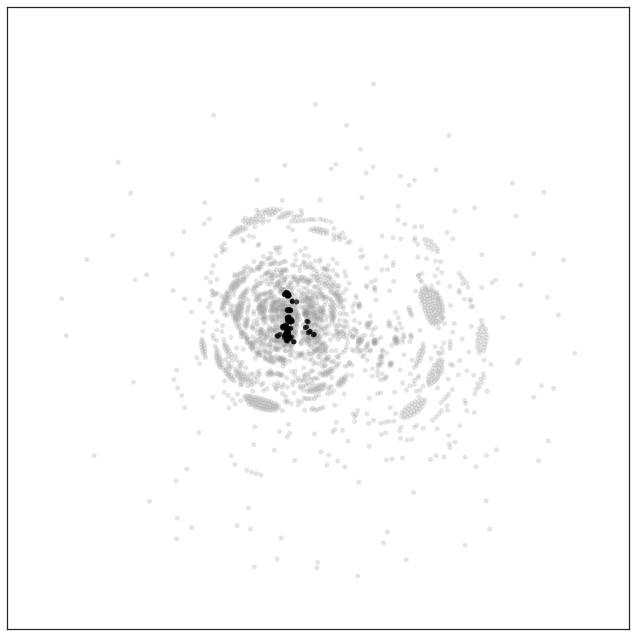

Comparison:ATB_v_LTBI


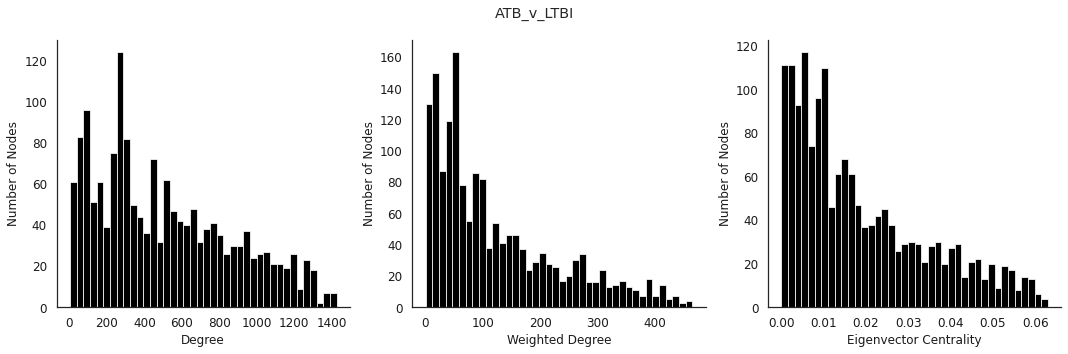

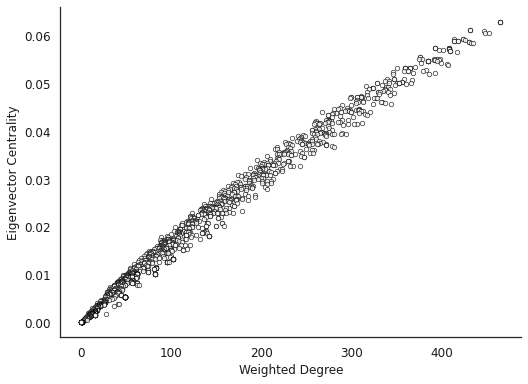

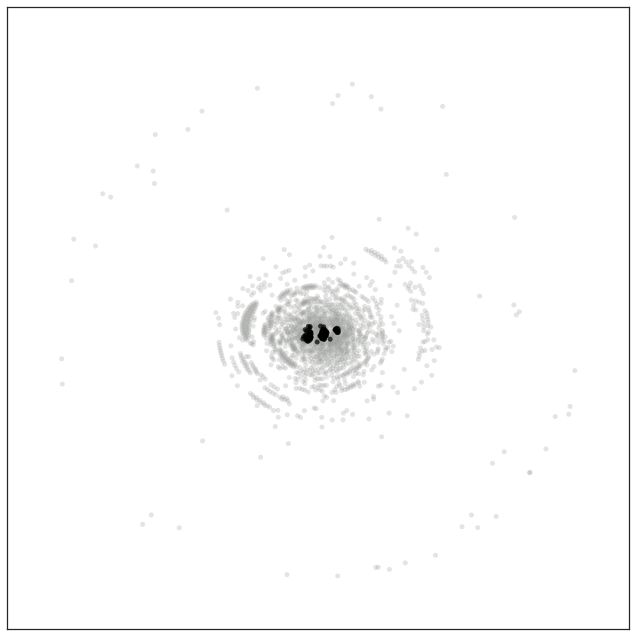

Comparison:ATB_v_OD


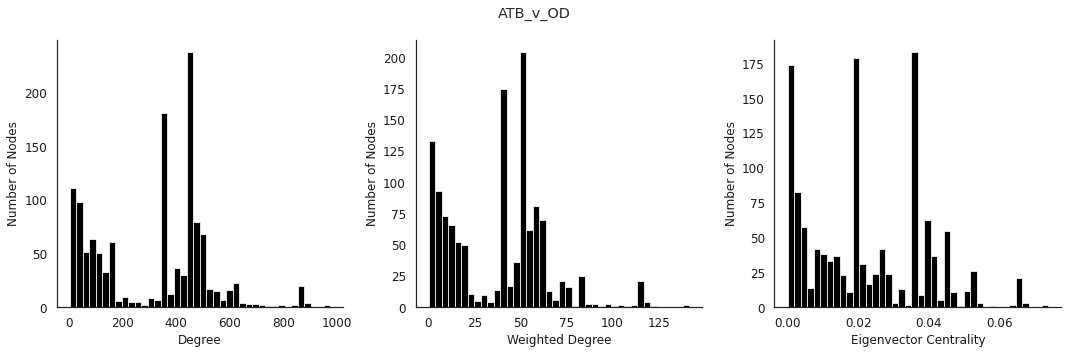

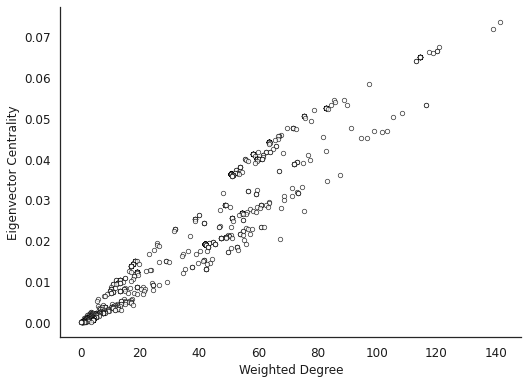

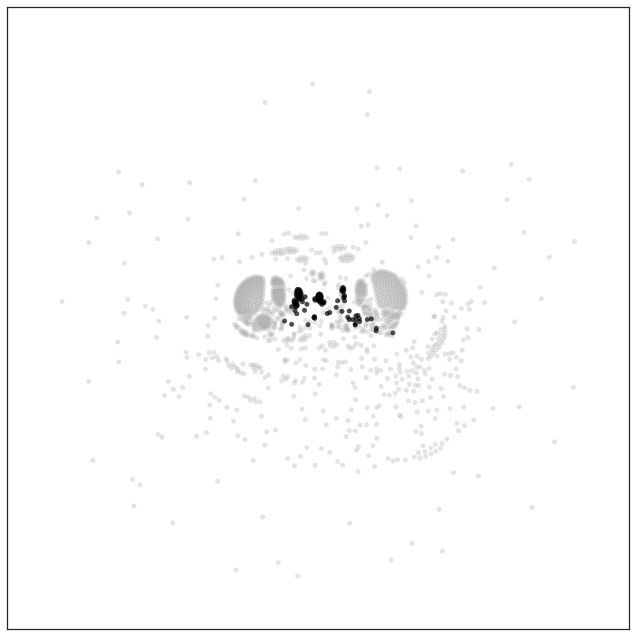

Comparison:ATB_v_Tret


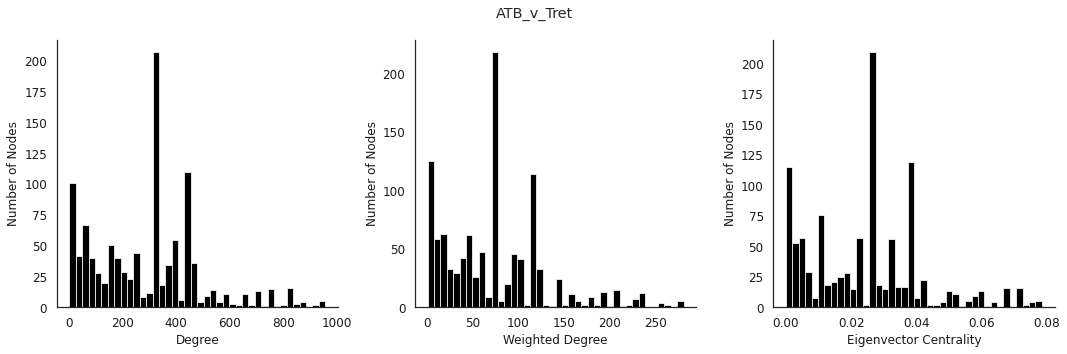

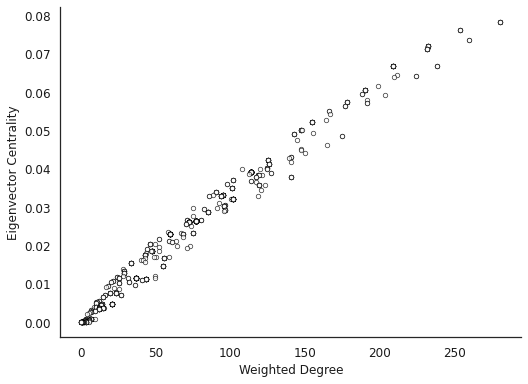

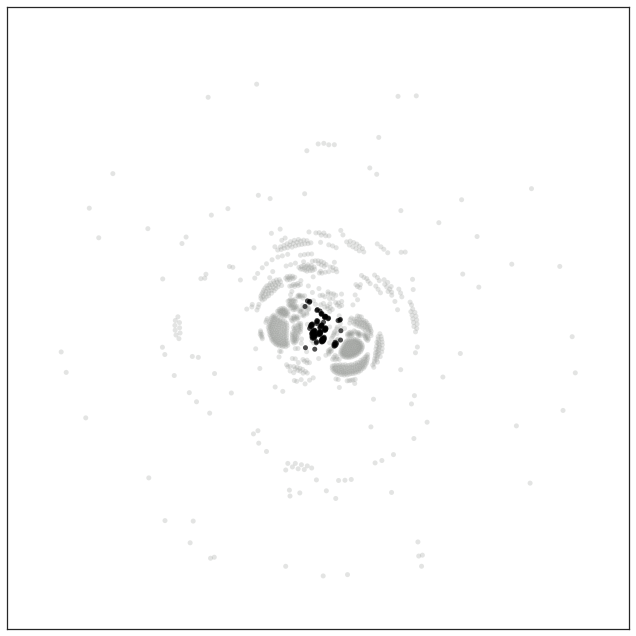

In [18]:
#Remove LTBI_v_HC comparison from now on
for e in comparisons:
    print('Comparison:'+e)
    #Load network
    G = nx.read_gpickle(pickled_objects_dir + '/network-files/networks/'+e+'.pkl')
    
    #Get a series of the **Degree** for each node
    node_list = [node_deg[0] for node_deg in list(G.degree())]
    degree_list = [node_deg[1] for node_deg in list(G.degree())]
    degree_series = pd.Series(degree_list , index = node_list).sort_values(ascending = False)
    
    #Get a series of the Weighted Degree for each node
    node_list = [node_deg[0] for node_deg in list(G.degree(weight = 'weight'))]
    degree_list = [node_deg[1] for node_deg in list(G.degree(weight = 'weight'))]
    weighted_degree_series = pd.Series(degree_list , index = node_list).sort_values(ascending = False)
    
    #Get a series of the **Eigenvector Centrality** for each node
    eigenvector_centrality_series = pd.Series(nx.eigenvector_centrality(G, weight = 'weight')).sort_values(ascending = False) #takes edge weight into account
    
    #Pickle Degree, Weighted Degree and Eigenvector Centrality series for comparison with other networks
    degree_series.to_pickle(pickled_objects_dir+'/network-files/degree-series/'+e+'.pkl')
    weighted_degree_series.to_pickle(pickled_objects_dir+'/network-files/weighted-degree-series/'+e+'.pkl')
    eigenvector_centrality_series.to_pickle(pickled_objects_dir+'/network-files/eigenvector-centrality-series/'+e+'.pkl')
    
    #Plot the distibution of centrality values for all nodes
    #network_building_fig4
    gAssem.centralityDist(e, degree_series, weighted_degree_series,eigenvector_centrality_series,publication_dir+'/network_building_fig3_'+e)
    #How does the ranking of centrality values between Weighted Degree and Eigenvector centrality compare?
    #network_building_fig4
    gAssem.cor_wdegree_eigenvector(weighted_degree_series,eigenvector_centrality_series,publication_dir+'/network_building_fig4_'+e)
    #Where are the 100 most central nodes located in the network?
    #network_building_fig5
    gAssem.draw_graph_and_color_subset_nodes(G, set(weighted_degree_series[0:100].index),publication_dir+'/network_building_fig5_'+e)

### 6. Get mean $log_2$(Fold Change) for all genes in network
- Create a series that stores the mean $log2(FC)$ across datasets from the $log2(FC)$ matrix (rows = genes & columns = datasets)
- when averaging $log2(FC)$ across datasets, **include all** datasets (columns) (including non-zero & zero)
- some datasets in which logFC for a gene = 0 are due to **q-value** threshold or **logFC** threshold or both

Comparison:ATB_v_HC


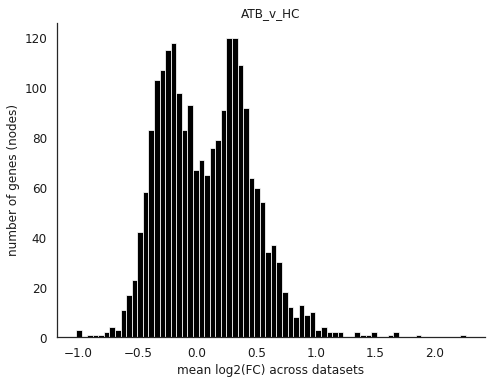

Comparison:ATB_v_LTBI


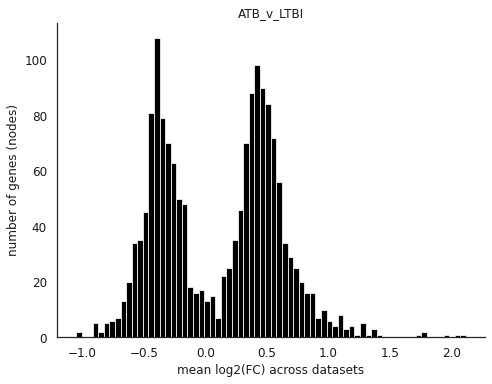

Comparison:ATB_v_OD


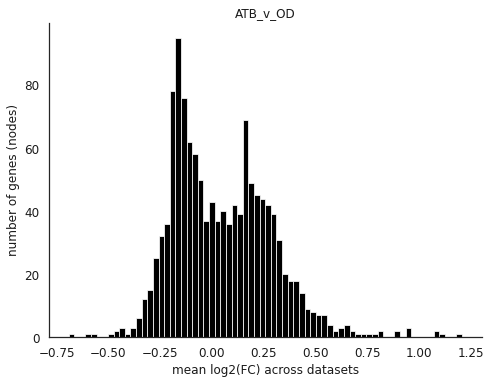

Comparison:ATB_v_Tret


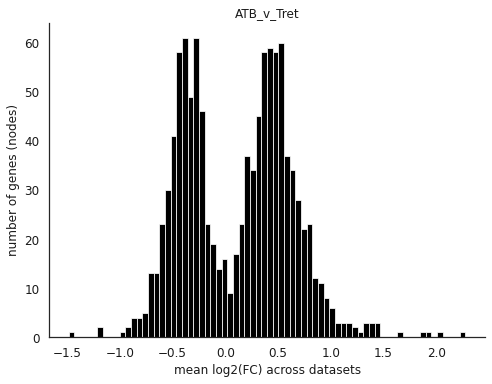

In [19]:
for e in comparisons:
    print('Comparison:'+e)
    #Load network
    G = nx.read_gpickle(pickled_objects_dir + '/network-files/networks/'+e+'.pkl')
    #Load gene expression
    #diff_gene_exp_df = pd.read_csv(pooled_diff_gene_exp_data+'/'+e+'_qval_thresh_0.05.csv',sep=',',index_col=0)
    diff_gene_exp_df = pd.read_csv(pooled_diff_gene_exp_data+'/'+e+'_fll.csv',sep=',',index_col=0)
    
    genes_in_network = list(G.nodes()) #get all nodes in the network
    mean_logFC_series = pd.Series(index = genes_in_network) #create series

    for gene_i in mean_logFC_series.index:
        #use code below to calculate average logFC for gene across ALL datasets/studies
        gene_i_mean_logFC = diff_gene_exp_df.loc[gene_i , :].mean()
        #append to series
        mean_logFC_series[gene_i] = gene_i_mean_logFC

    mean_logFC_series.sort_values(inplace = True, ascending = False)
    #print(mean_logFC_series.head(n = 5))
    #print(mean_logFC_series.tail(n = 5))
    
    #Plot the distribution of mean logFC for genes (nodes) in the network
    #network_building_fig6
    gAssem.meanlogFC_Dis(mean_logFC_series,e,publication_dir+'/network_building_fig6_'+e)
    
    #Pickle mean 𝑙𝑜𝑔2(𝐹𝐶) series for comparison with other networks and downstream analysis
    mean_logFC_series.to_pickle(pickled_objects_dir+'/network-files/mean-logFC-network-nodes-series/'+e+'.pkl')